# Summarize shared genes

In [1]:
import functools
import pandas as pd
from gtfparse import read_gtf

In [2]:
@functools.lru_cache()
def get_gtf(gtf_file):
    return read_gtf(gtf_file)


In [4]:
def gene_annotation(gtf_file, feature):
    gtf0 = get_gtf(gtf_file)
    gtf = gtf0[gtf0["feature"] == feature]
    return gtf[["gene_id", "gene_name", "transcript_id", "exon_id", 
                "gene_type", "seqname", "start", "end", "strand"]]

In [5]:
gtf_file = '/ceph/genome/human/gencode25/gtf.CHR/_m/gencode.v25.annotation.gtf'
gtf_annot = gene_annotation(gtf_file, 'gene')
gtf_annot.head(2)

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_status', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_status', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


,gene_id,gene_name,transcript_id,exon_id,gene_type,seqname,start,end,strand
0,ENSG00000223972.5,DDX11L1,,,transcribed_unprocessed_pseudogene,chr1,11869,14409,+
12,ENSG00000227232.5,WASH7P,,,unprocessed_pseudogene,chr1,14404,29570,-


In [7]:
shared_file = "../../../upset_plots/_m/BrainSeq_shared_degs_annotation.txt"
shared_df = pd.read_csv(shared_file, sep='\t')\
              .merge(gtf_annot, on=['gene_id', 'gene_name', 'seqname'])
shared_df.head(2)

,gene_id,ensemblID,seqname,gene_name,Dir,transcript_id,exon_id,gene_type,start,end,strand
0,ENSG00000272977.1,ENSG00000272977,chr22,CTA-390C10.10,1.0,,,sense_intronic,25476218,25479971,+
1,ENSG00000233913.7,ENSG00000233913,chr5,CTC-575D19.1,-1.0,,,processed_pseudogene,168616352,168616996,+


In [19]:
counts = shared_df.groupby('gene_type').size().reset_index().rename(columns={0:'counts'})
counts.head(2)

,gene_type,counts
0,Mt_tRNA,1
1,TEC,11


<AxesSubplot:xlabel='gene_type'>

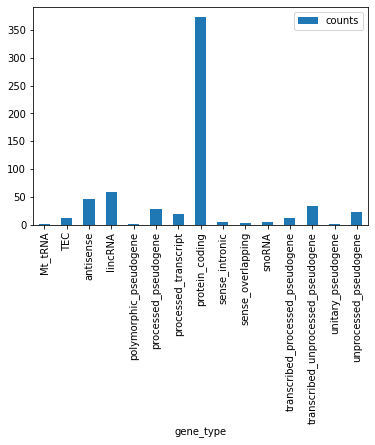

In [23]:
counts.plot.bar(x='gene_type', y='counts')

In [33]:
modality = shared_df.merge(pd.read_csv("../../_m/shared_modality_annotated.tsv", sep='\t'), 
                           on="ensemblID")
new_counts = modality.groupby(['Modal_Category', 'gene_type', "Tissue"])\
                     .size().reset_index().rename(columns={0:'counts'})
new_counts.head(2)

,Modal_Category,gene_type,Tissue,counts
0,Multi_vs_Multi,TEC,Caudate,1
1,Multi_vs_Multi,TEC,DLPFC,1


In [9]:
%load_ext rpy2.ipython

In [107]:
%%R -i new_counts
library(ggpubr)
library(tidyverse)

save_ggplots <- function(p, fn, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

plot_prop <- function(new_counts, mod_cat){
    dt = new_counts %>% filter(Modal_Category == mod_cat) %>% 
        mutate_if(is.character, as.factor) %>% 
        group_by(Tissue, Modal_Category, gene_type) %>% 
        tally(counts) %>% mutate(prop = prop.table(n)) 
    bp = ggbarplot(dt, x="gene_type", y="prop", fill="Tissue",
               palette="npg", facet.by="Modal_Category", xlab="", 
               ylab="Proportion", position=position_dodge(), 
               panel.labs.font=list(face='bold', size=16), 
               legend="right", orientation="horiz") + ylim(0, 0.8) + 
        rotate_x_text(45) + font("xy.title", size = 18, face = "bold") +
        font("xy.text", size = 16) + 
        font("legend.title", size=18, face="bold") +
        font("legend.text", size=16)
    save_ggplots(bp, paste0("proportion_geneType_shared_DEGs_acrossRegion_", 
                            mod_cat), 8, 4)
    return(bp)
}

ovo <- plot_prop(new_counts, "One_vs_One")
mvo <- plot_prop(new_counts, "Multi_vs_One")
ovm <- plot_prop(new_counts, "One_vs_Multi")
mvm <- plot_prop(new_counts, "Multi_vs_Multi")

In [108]:
%%R
fig = ggarrange(ovo, mvo, ovm, mvm, ncol = 2, nrow = 2, 
          common.legend = TRUE, legend="bottom")
save_ggplots(fig, "allplots_proportion_shared", 14, 9)